## Forecasting System - Project Demand of Products at a Retail Outlet Based on historical data

In [1]:
#importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse

import warnings       
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')

In [2]:
#reading data to python environment
pd.set_option('display.max_columns', 9994)
df = pd.read_excel("Sample - Superstore.xls")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## Exploratory Data Analysis

In [3]:
df.shape

(9994, 21)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [5]:
df.corr()['Sales']

Row ID        -0.001359
Postal Code   -0.023854
Sales          1.000000
Quantity       0.200795
Discount      -0.028190
Profit         0.479064
Name: Sales, dtype: float64

## Indexing time series data

In [6]:
df = df.set_index(['Order Date'])

In [7]:
df.index.min(), df.index.max()

(Timestamp('2014-01-03 00:00:00'), Timestamp('2017-12-30 00:00:00'))

 #### Note:
 - The dataset used for this project is a superstore data from 2014 to 2018 containing 9994 entries and 21 features and this is a time series data.
 - Dataset contains object, float and integer Data types and the date columns are already in datetime format.
 - there is no feature having strong correlation with sales feature.
 - For forecasting, we are using mainly the Sales Data with the order data of different product categories.

## Visualising Data

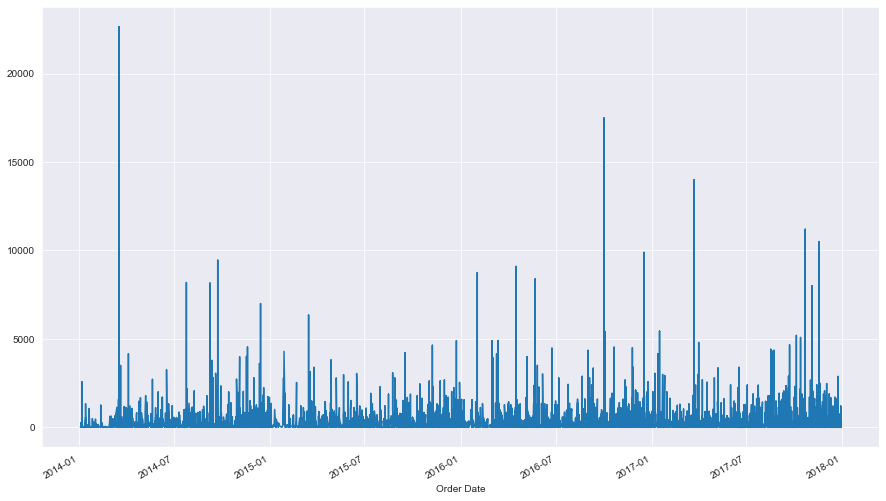

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 9
df['Sales'].plot();

## Resampling Data

Order Date
2014-01-01    180.213861
2014-02-01     98.258522
2014-03-01    354.719803
2014-04-01    209.595148
2014-05-01    193.838418
2014-06-01    256.260204
2014-07-01    237.387364
2014-08-01    182.414827
2014-09-01    305.139369
2014-10-01    197.820082
2014-11-01    247.260115
2014-12-01    250.164103
2015-01-01    313.346131
2015-02-01    186.740797
2015-03-01    280.625014
2015-04-01    213.720053
2015-05-01    206.381414
2015-06-01    179.690522
2015-07-01    205.466607
2015-08-01    232.064982
2015-09-01    220.463884
2015-10-01    189.186286
2015-11-01    234.483221
2015-12-01    237.087092
2016-01-01    208.342596
2016-02-01    276.853193
2016-03-01    317.275307
2016-04-01    227.941406
2016-05-01    253.278791
2016-06-01    202.736352
2016-07-01    195.333149
2016-08-01    176.791899
2016-09-01    202.231474
2016-10-01    304.529311
2016-11-01    214.626935
2016-12-01    275.565463
2017-01-01    283.686284
2017-02-01    189.730219
2017-03-01    247.362827
2017-04-01    

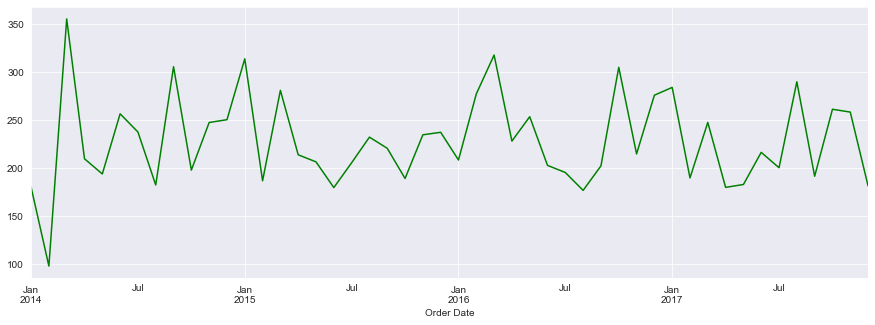

In [9]:
#monthly mean sales begin
mean_monthlysales = df.resample(rule='MS').mean()['Sales']
print(mean_monthlysales)
mean_monthlysales.plot(figsize=(15,5),c='green')
plt.show()

 #### Note:
 - Mean monthly sales is maximum in month march of year 2014. 
 - Also on month sep 2014, jan 2015, march 2016, oct 2016 shows higher sales.
 - There is a huge dip in the graph during feb 2014 which shows least sales.

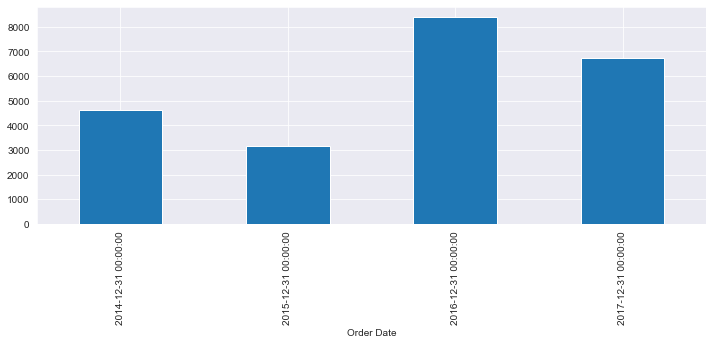

In [10]:
df.resample(rule='A').max()['Profit'].plot(kind='bar', figsize = (12,4))
plt.show()

###### Note: maximum profit is observed in the year 2016 and least in year 2015.

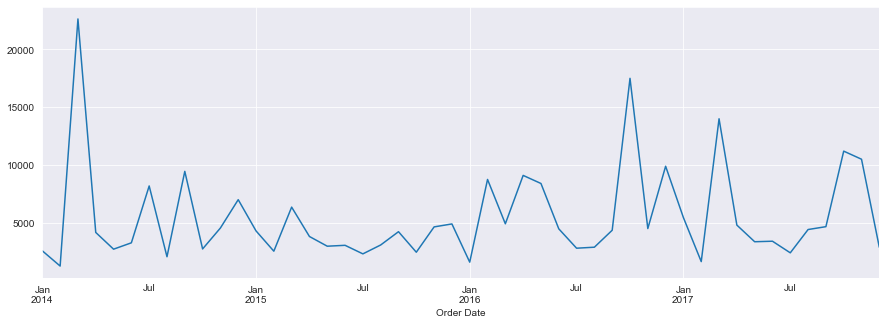

In [11]:
#MAX MONTHLY SALES
df.resample(rule='M').max()['Sales'].plot(figsize= (15,5))
plt.show()

#### Note: Eventhough, Maximum sales observed to be in year 2014 profit is more on year 2016 as seen from above two graphs.

## Data Pre-processing

In [12]:
#checking for unique values in columns
{column: len(df[column].unique()) for column in df.columns}

{'Row ID': 9994,
 'Order ID': 5009,
 'Ship Date': 1334,
 'Ship Mode': 4,
 'Customer ID': 793,
 'Customer Name': 793,
 'Segment': 3,
 'Country': 1,
 'City': 531,
 'State': 49,
 'Postal Code': 631,
 'Region': 4,
 'Product ID': 1862,
 'Category': 3,
 'Sub-Category': 17,
 'Product Name': 1850,
 'Sales': 6144,
 'Quantity': 14,
 'Discount': 12,
 'Profit': 7545}

In [13]:
df = df.copy()
#dropping unnecessary columns    
df = df.drop(['Row ID','Country','Customer Name','Product Name','Order ID','Customer ID'],axis=1)

In [14]:
df.shape

(9994, 14)

In [15]:
#checking for missing values
df.isna().sum()

Ship Date       0
Ship Mode       0
Segment         0
City            0
State           0
Postal Code     0
Region          0
Product ID      0
Category        0
Sub-Category    0
Sales           0
Quantity        0
Discount        0
Profit          0
dtype: int64

#### Note: The Dataset not containing any missing values.

In [16]:
#checking different categories in 'category' column
df['Category'].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [103]:
# Since dataset contain multiple categories of products we have to create seperate Dataframes for each category for analysis.

### FURNITURE

In [17]:
#selecting rows where category is furniture
furniture_data = df.loc[df['Category'] == 'Furniture']
furniture_data

,Ship Date,Ship Mode,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,
2016-11-08,2016-11-11,Second Class,Consumer,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,261.9600,2,0.00,41.9136
2016-11-08,2016-11-11,Second Class,Consumer,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,731.9400,3,0.00,219.5820
2015-10-11,2015-10-18,Standard Class,Consumer,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,957.5775,5,0.45,-383.0310
2014-06-09,2014-06-14,Standard Class,Consumer,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,48.8600,7,0.00,14.1694
2014-06-09,2014-06-14,Standard Class,Consumer,Los Angeles,California,90032,West,FUR-TA-10001539,Furniture,Tables,1706.1840,9,0.20,85.3092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-03-19,2015-03-22,First Class,Home Office,Houston,Texas,77041,Central,FUR-BO-10004218,Furniture,Bookcases,383.4656,4,0.32,-67.6704
2016-12-05,2016-12-10,Second Class,Corporate,Newark,Delaware,19711,East,FUR-FU-10002671,Furniture,Furnishings,13.4000,1,0.00,6.4320
2015-09-06,2015-09-09,Second Class,Consumer,Lafayette,Louisiana,70506,South,FUR-TA-10001039,Furniture,Tables,85.9800,1,0.00,22.3548


In [18]:
col = ['Ship Date','Ship Mode','Segment','City','State','Postal Code','Region','Product ID','Category','Sub-Category','Quantity','Discount','Profit']
furniture_data.drop(col,axis=1, inplace=True)

In [19]:
furniture_data.head()

,Sales
Order Date,
2016-11-08,261.9600
2016-11-08,731.9400
2015-10-11,957.5775
2014-06-09,48.8600
2014-06-09,1706.1840


In [20]:
#sorting by order date
furniture_data = furniture_data.sort_values('Order Date')
furniture_data

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,545.940
...,...
2017-12-29,258.750
2017-12-29,1207.840
2017-12-29,101.120


In [21]:
furniture_data.describe()

,Sales
count,2121.000000
mean,349.834887
std,503.179145
min,1.892000
25%,47.040000
50%,182.220000
75%,435.168000
max,4416.174000


In [22]:
furniture_data.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-13', '2014-01-14', '2014-01-16',
               '2014-01-19', '2014-01-20',
               ...
               '2017-12-28', '2017-12-28', '2017-12-28', '2017-12-29',
               '2017-12-29', '2017-12-29', '2017-12-29', '2017-12-29',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=2121, freq=None)

In [23]:
#taking monthly mean sales of category furniture
y_furniture = furniture_data['Sales'].resample('MS').mean()

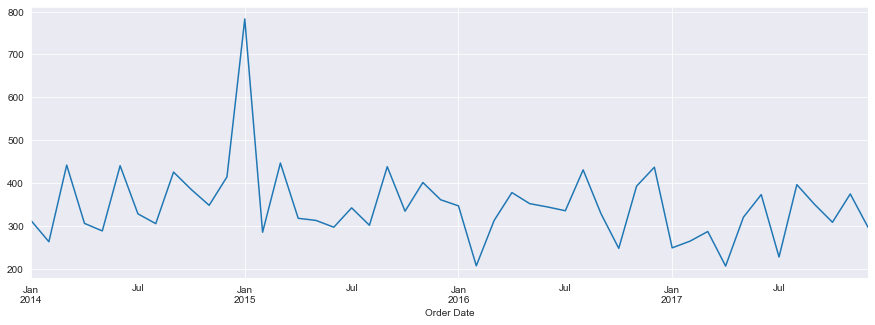

In [24]:
#observing mean monthly sales of furnitures
y_furniture.plot(figsize = (15,5))
plt.show()

Note: average sales is maximum at Jan 2015.

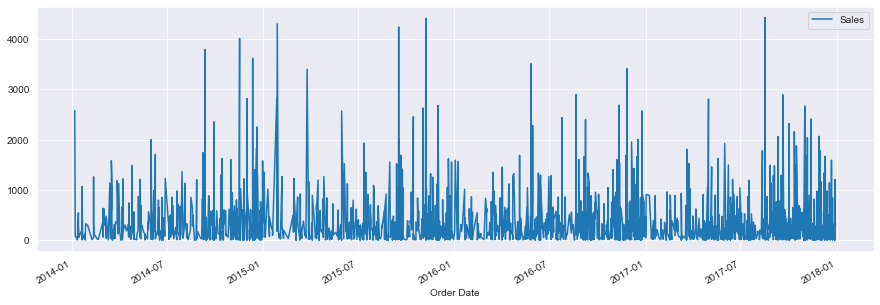

In [25]:
furniture_data.plot(figsize=(15,5))
plt.show()

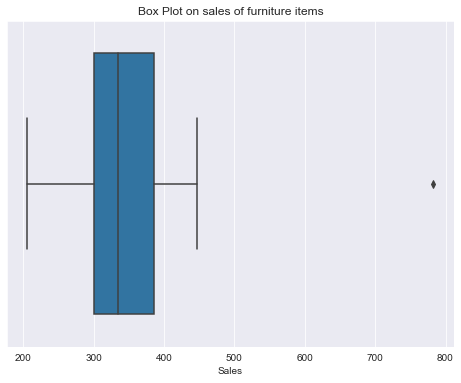

In [26]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(y_furniture).set_title('Box Plot on sales of furniture items')
plt.show()

### OFFICE SUPPLIES

In [27]:
office_supplies_data = df.loc[df['Category'] == 'Office Supplies']
office_supplies_data

,Ship Date,Ship Mode,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,
2016-06-12,2016-06-16,Second Class,Corporate,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,14.620,2,0.0,6.8714
2015-10-11,2015-10-18,Standard Class,Consumer,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,22.368,2,0.2,2.5164
2014-06-09,2014-06-14,Standard Class,Consumer,Los Angeles,California,90032,West,OFF-AR-10002833,Office Supplies,Art,7.280,4,0.0,1.9656
2014-06-09,2014-06-14,Standard Class,Consumer,Los Angeles,California,90032,West,OFF-BI-10003910,Office Supplies,Binders,18.504,3,0.2,5.7825
2014-06-09,2014-06-14,Standard Class,Consumer,Los Angeles,California,90032,West,OFF-AP-10002892,Office Supplies,Appliances,114.900,5,0.0,34.4700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-22,2016-09-28,Standard Class,Consumer,Grand Rapids,Michigan,49505,Central,OFF-PA-10002195,Office Supplies,Paper,35.560,7,0.0,16.7132
2015-05-17,2015-05-23,Standard Class,Consumer,Long Beach,New York,11561,East,OFF-LA-10003766,Office Supplies,Labels,31.500,10,0.0,15.1200
2015-05-17,2015-05-23,Standard Class,Consumer,Long Beach,New York,11561,East,OFF-SU-10000898,Office Supplies,Supplies,55.600,4,0.0,16.1240


In [28]:
office_supplies_data.drop(col,axis=1, inplace=True)

In [29]:
office_supplies_data = office_supplies_data.sort_values('Order Date')
office_supplies_data.head()

,Sales
Order Date,
2014-01-03,16.448
2014-01-04,272.736
2014-01-04,11.784
2014-01-04,3.540
2014-01-05,19.536


In [30]:
office_supplies_data.describe()

,Sales
count,6026.000000
mean,119.324101
std,382.182228
min,0.444000
25%,11.760000
50%,27.418000
75%,79.920000
max,9892.740000


In [31]:
office_supplies_data.index

DatetimeIndex(['2014-01-03', '2014-01-04', '2014-01-04', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-06', '2014-01-06',
               '2014-01-06', '2014-01-06',
               ...
               '2017-12-29', '2017-12-29', '2017-12-29', '2017-12-29',
               '2017-12-29', '2017-12-30', '2017-12-30', '2017-12-30',
               '2017-12-30', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=6026, freq=None)

In [32]:
y_office = office_supplies_data['Sales'].resample('MS').mean()

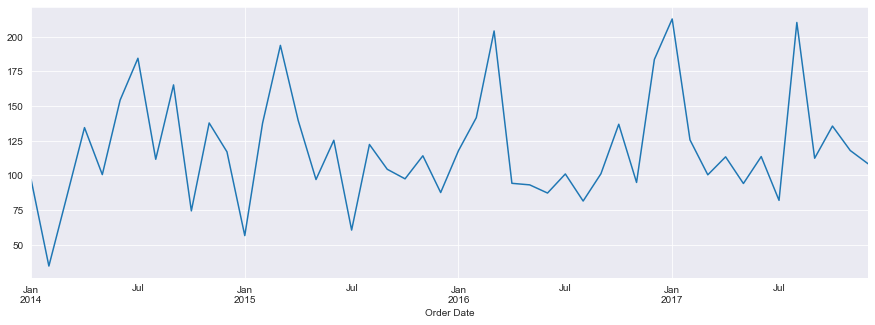

In [33]:
y_office.plot(figsize = (15,5))
plt.show()

Sales for office supplies shows maximum at start of year between feb to april and minimum at end of year.

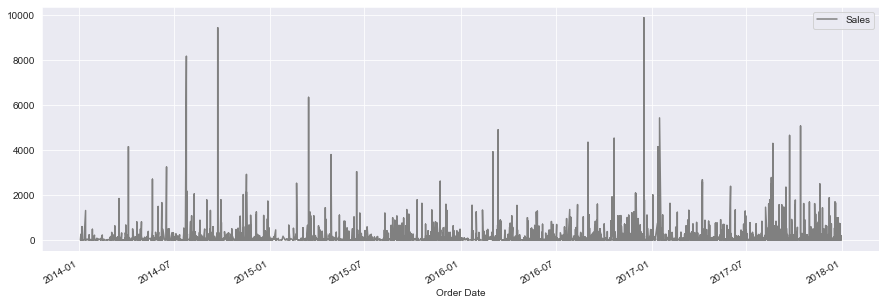

In [34]:
office_supplies_data.plot(figsize=(15,5), c = 'grey')
plt.show()

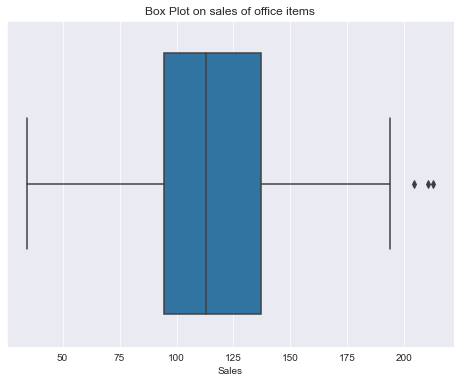

In [35]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(y_office).set_title('Box Plot on sales of office items')
plt.show()

## Technology items

In [36]:
technology_data = df.loc[df['Category'] == 'Technology']
technology_data

,Ship Date,Ship Mode,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,
2014-06-09,2014-06-14,Standard Class,Consumer,Los Angeles,California,90032,West,TEC-PH-10002275,Technology,Phones,907.152,6,0.2,90.7152
2014-06-09,2014-06-14,Standard Class,Consumer,Los Angeles,California,90032,West,TEC-PH-10002033,Technology,Phones,911.424,4,0.2,68.3568
2014-08-27,2014-09-01,Second Class,Consumer,San Francisco,California,94109,West,TEC-PH-10001949,Technology,Phones,213.480,3,0.2,16.0110
2016-01-16,2016-01-20,Second Class,Consumer,Los Angeles,California,90049,West,TEC-AC-10003027,Technology,Accessories,90.570,3,0.0,11.7741
2016-12-08,2016-12-10,First Class,Corporate,Richardson,Texas,75080,Central,TEC-PH-10004977,Technology,Phones,1097.544,7,0.2,123.4737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-22,2016-09-28,Standard Class,Consumer,Grand Rapids,Michigan,49505,Central,TEC-PH-10001305,Technology,Phones,97.980,2,0.0,27.4344
2016-09-29,2016-10-03,Standard Class,Consumer,Los Angeles,California,90008,West,TEC-AC-10003399,Technology,Accessories,36.240,1,0.0,15.2208
2017-11-17,2017-11-21,Standard Class,Corporate,Athens,Georgia,30605,South,TEC-AC-10001539,Technology,Accessories,79.990,1,0.0,28.7964


In [37]:
technology_data.drop(col,axis=1, inplace=True)

In [38]:
technology_data = technology_data.sort_values('Order Date')

In [39]:
technology_data.describe()

,Sales
count,1847.000000
mean,452.709276
std,1108.655848
min,0.990000
25%,68.016000
50%,166.160000
75%,448.534000
max,22638.480000


In [40]:
technology_data.index

DatetimeIndex(['2014-01-06', '2014-01-06', '2014-01-09', '2014-01-13',
               '2014-01-15', '2014-01-16', '2014-01-20', '2014-01-26',
               '2014-01-26', '2014-02-01',
               ...
               '2017-12-24', '2017-12-24', '2017-12-25', '2017-12-25',
               '2017-12-25', '2017-12-25', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=1847, freq=None)

In [41]:
technology_data.index.min(), technology_data.index.max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [42]:
y_technology = technology_data['Sales'].resample('MS').mean()

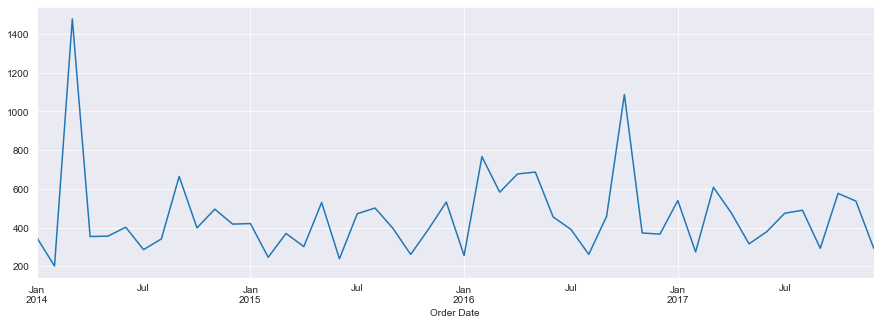

In [43]:
y_technology.plot(figsize = (15,5))
plt.show()

Technology items have highest sales in march 2014 and also in oct-nov of 2016.

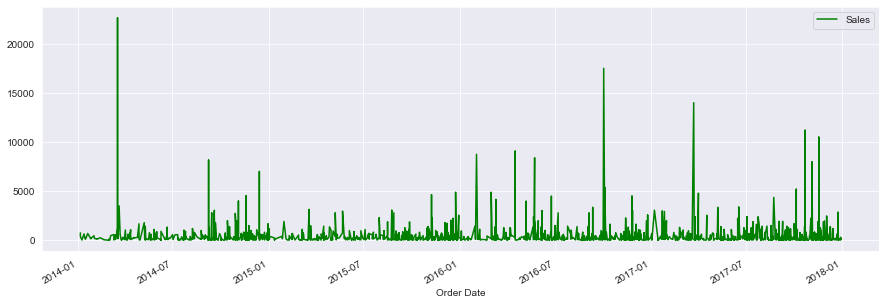

In [44]:
technology_data.plot(figsize=(15,5), c = 'green', legend = True)
plt.show()

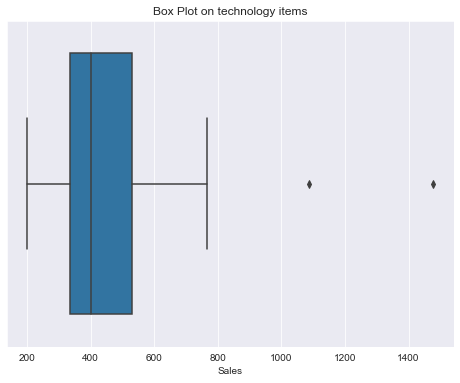

In [45]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(y_technology).set_title('Box Plot on technology items')
plt.show()

## Seasonal Decomposition of each category

### Furniture items

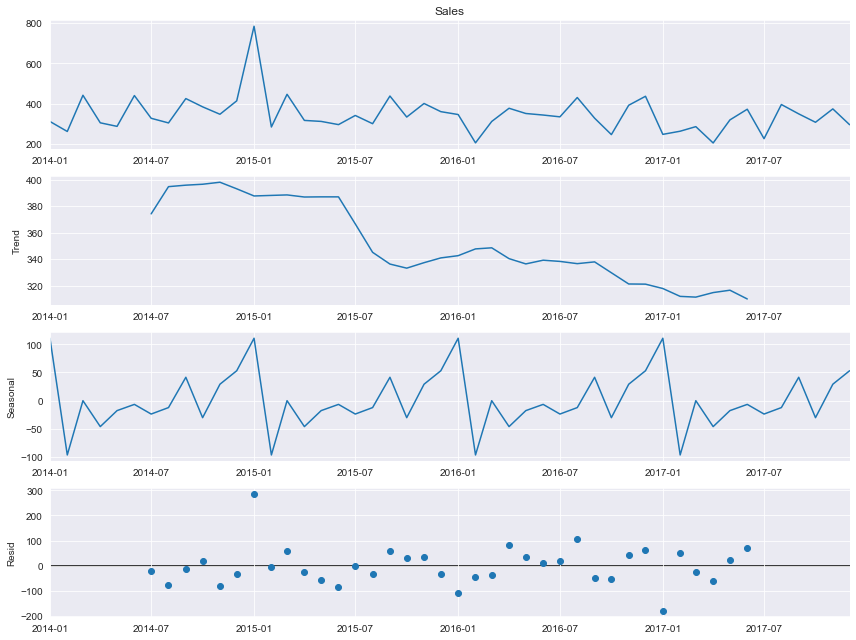

In [46]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 9
decomposition = sm.tsa.seasonal_decompose(y_furniture, model='additive')
fig = decomposition.plot()
plt.show()

 - Decreasing trend is observed for the sales of furniture after 2015.

### Office items

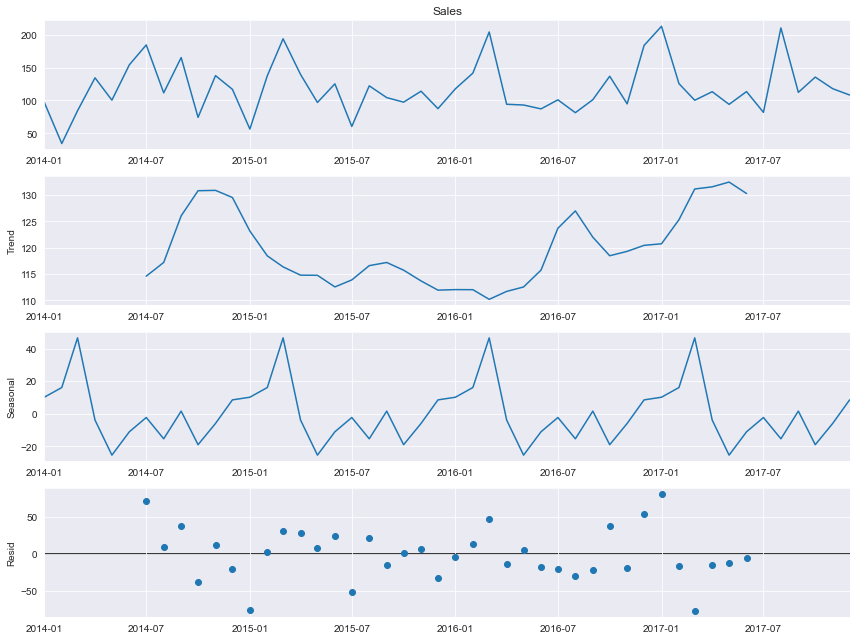

In [47]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 9
decomposition = sm.tsa.seasonal_decompose(y_office, model='additive')
fig = decomposition.plot()
plt.show()

From the trend graph,there is a rise in curve and reaches a maximum at middle of 2014 after that there is huge fall in sales from 2015 to 2016. Then it gradually rises reach a maximum at beginning of 2016 and repeats.

### Technology

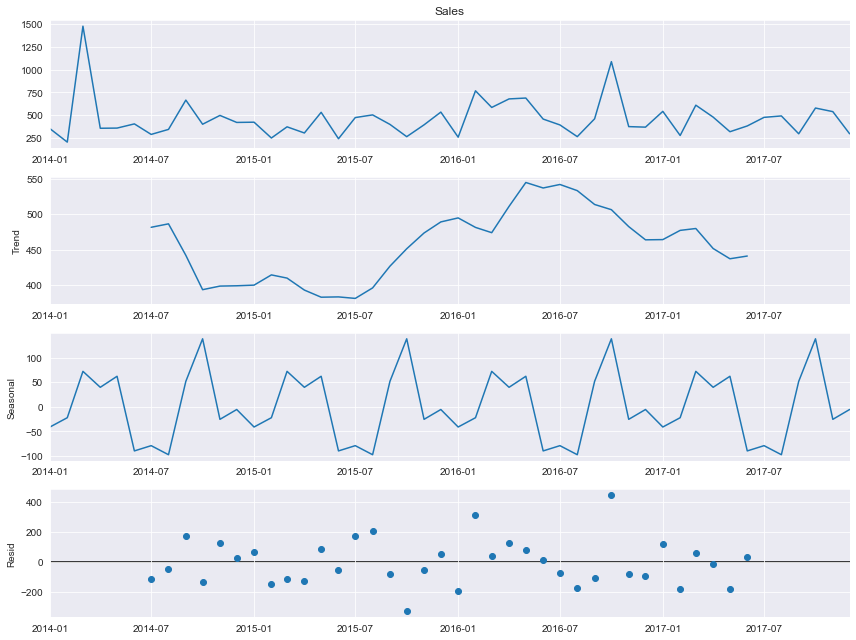

In [48]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 9
decomposition = sm.tsa.seasonal_decompose(y_technology, model='additive')
fig = decomposition.plot()
plt.show()

huge rise in sales is observed from middle of 2015 to first half of 2016 after that falls.

## Test for stationarity

In [49]:
#Augmented dickey-fuller test
#H0 : data is non stationary (unit root =1)
#H1 : data is stationery (unit root <1)

def adfuller_test(series):
    result = adfuller(series)
    labels = ['ADF test statistic', 'p-value', 'Number of observations used', '#lags used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
        
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [50]:
adfuller_test(y_furniture)

ADF test statistic : -6.962405221214862
p-value : 9.093398510006677e-10
Number of observations used : 0
#lags used : 47
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [51]:
adfuller_test(y_office)

ADF test statistic : -6.100365254423854
p-value : 9.869101392257589e-08
Number of observations used : 0
#lags used : 47
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [52]:
adfuller_test(y_technology)

ADF test statistic : -7.872567069771644
p-value : 4.9402068103522035e-12
Number of observations used : 0
#lags used : 47
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


#### Findings: 
 - The p-value<0.05, so rejecting null hypothesis and assume a stationery datasets. 
 - Here the differencing value (d) is zero.

## Autocorrelation and Partial Autocorrelation plots

ACF measures correlation between the time series with a lagged version itself and PACF similiar to ACF but after eliminating the variations.

In [53]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#### Furniture

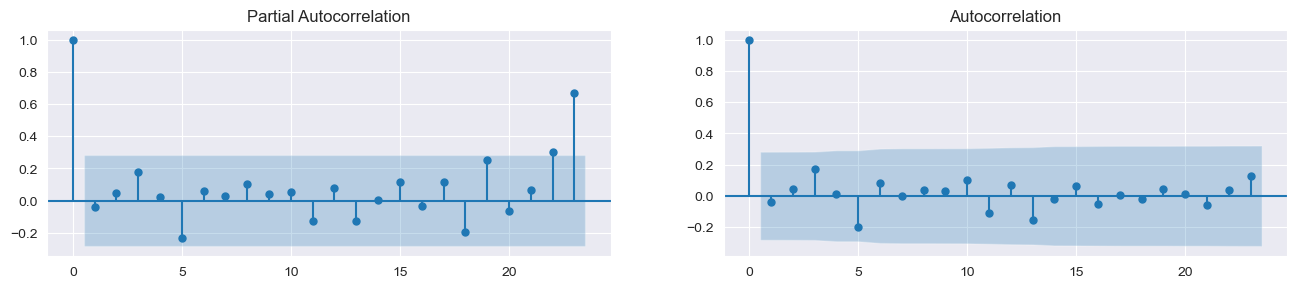

In [54]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
sm.graphics.tsa.plot_pacf(y_furniture,lags=23,method="ols",ax=axes[0])
sm.graphics.tsa.plot_acf(y_furniture, lags=23,ax=axes[1])
plt.show()

#### Office supplies

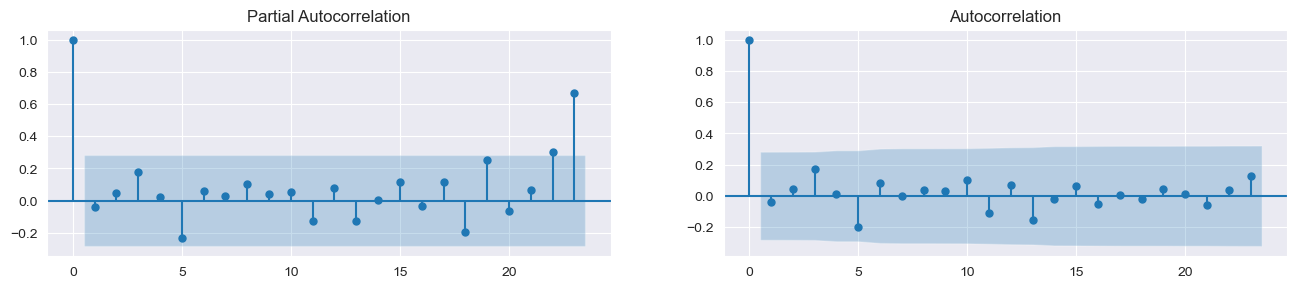

In [55]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
sm.graphics.tsa.plot_pacf(y_furniture,lags=23,method="ols",ax=axes[0])
sm.graphics.tsa.plot_acf(y_furniture, lags=23,ax=axes[1])
plt.show()

#### Technology

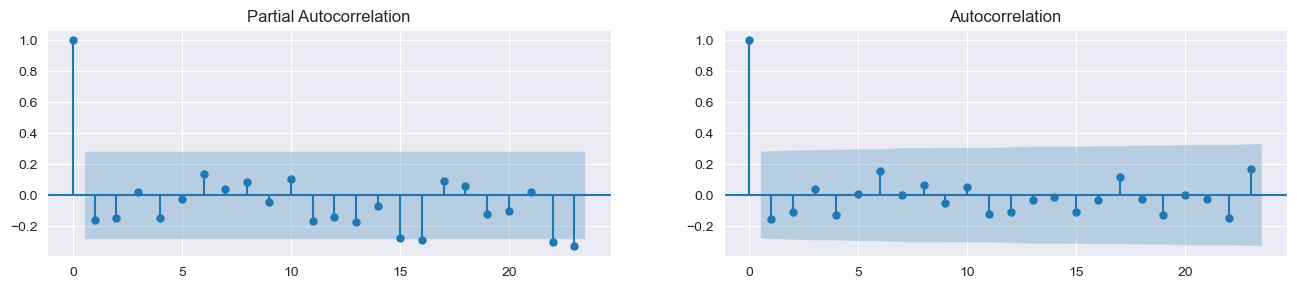

In [56]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
sm.graphics.tsa.plot_pacf(y_technology,lags=23,method="ols",ax=axes[0])
sm.graphics.tsa.plot_acf(y_technology, lags=23,ax=axes[1])
plt.show()

## Parameter selection

Parameters of the ARIMA model are defined by 
 - AR(p)-lag order
 - I(d) -degree of difference
 - MA(q) - order of moving average 
    
SARIMAX an extension of ARIMA supports time series data with a seasonal component. it is denoted by order (p,d,q)(P,D,Q)m.
 - P - Seasonal regression
 - D - differencing
 - Q - moving average coefficients
 - m - no.of datapoints in each seasonal cycle

In [57]:
# Defining p,d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA are as follows:-')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA are as follows:-
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


## Furniture

### Grid search 

In [59]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(y_furniture,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:688.3112416991725
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1565.977281468862
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:426.2046489859171
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:272.091984762829
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:452.8238602501691
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1571.0201242562
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:295.44645647223496
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:274.09198456327965
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:641.1240680665804
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2671.215658209401
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:416.5496453364607
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:262.5230517047702
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:455.1588765434245
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2430.5547358352637
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:297.44640662503576
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:264.5230013128144
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:580.638926970597
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1382.1444044419063
ARIMA(0, 

AIC is an estimates relative quality of model and desired result is to fing lowest possible AIC score.
The (p,d,q)(P,D,Q,m) order (0, 1, 1)(0, 1, 1, 12) have lower AIC value of 251.2470.

In [60]:
#fitting ARIMA model with best parameters
model = sm.tsa.statespace.SARIMAX(y_furniture,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                #enforce_stationarity=False,
                                enforce_invertibility=False)

results = model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000   1892.758     -0.001      1.000   -3710.737    3708.737
ma.S.L12      -1.0000   1892.824     -0.001      1.000   -3710.867    3708.866
sigma2      7504.4474      0.180   4.17e+04      0.000    7504.095    7504.800


### Model diagnosis

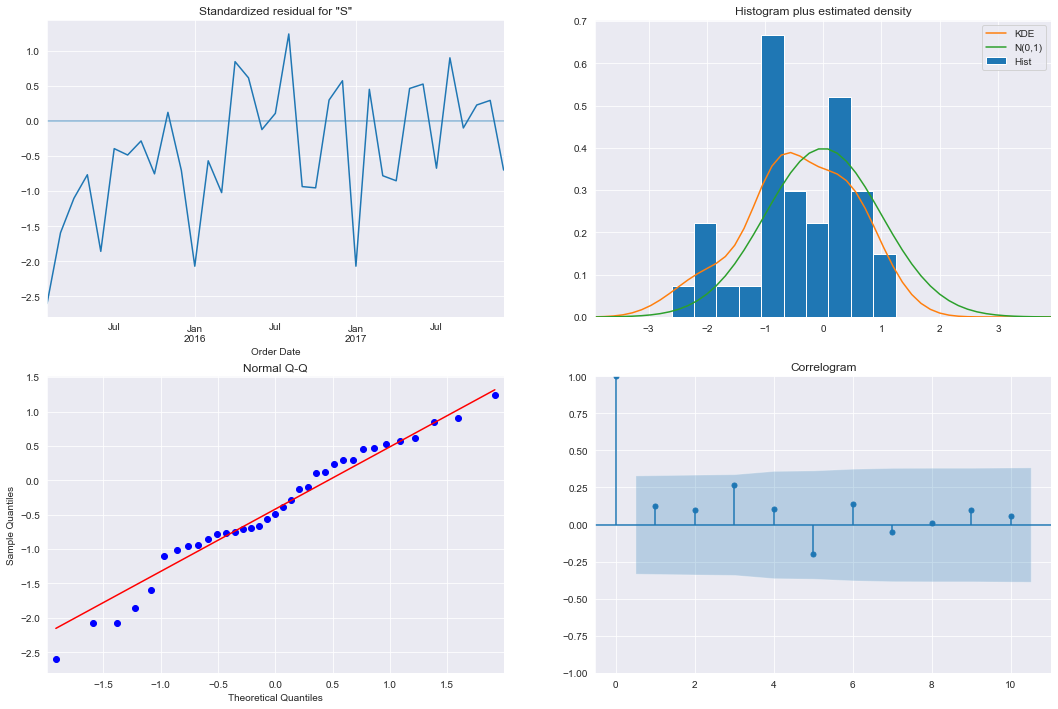

In [61]:
results.plot_diagnostics(figsize=(18, 12))
plt.show()

##### Note:
From above plots,it is clear that the residuals are almost normally distributed and uncorrelated.

## Visualising Forecasts

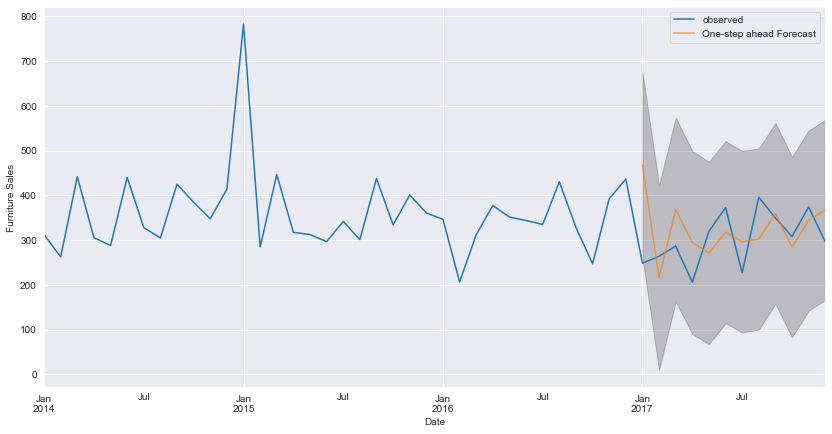

In [62]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y_furniture['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()


In [63]:
y_forecasted = pred.predicted_mean
y_truth = y_furniture['2017-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 7555.04
The Root Mean Squared Error of our forecasts is 86.92


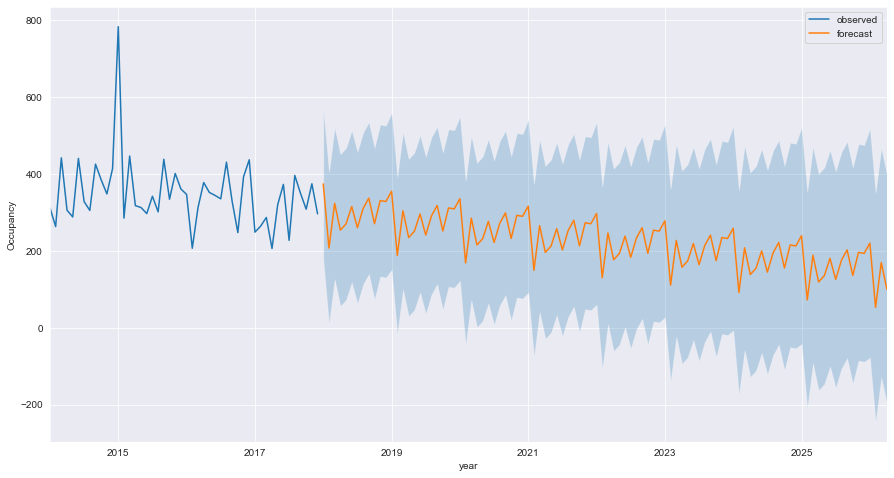

In [64]:
# Get forecast 100 steps ahead in future
pred = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred.conf_int()

ax = y_furniture.plot(label='observed', figsize=(15, 8))

pred.predicted_mean.plot(ax=ax, label='forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], alpha=0.25)

ax.set_xlabel('year')
ax.set_ylabel('Occupancy')

plt.legend()
plt.show()

Plot shows a decreasing trend of sales of furniture items.

## office supplies

In [66]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_office,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:589.5002315061224
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1347.4267897981113
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:383.41755111407554
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:248.8928413116318
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:394.83867919808836
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1348.9258329412073
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:260.5044719309093
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:250.10262158195803
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:545.8315751699361
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2552.5155905373776
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:371.8194830276595
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:240.39856988639355
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:396.4373424315812
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2337.8547617140594
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:262.173516381938
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:242.26144570286047
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:496.8049609774628
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1183.5722634375454
A

ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:231.55283799226888 have lower AIC value

In [111]:
model = sm.tsa.statespace.SARIMAX(y_office,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                #enforce_stationarity=False,
                                enforce_invertibility=False)
#fitting model
results = model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8436      0.117     -7.239      0.000      -1.072      -0.615
ma.S.L12      -1.0001      0.201     -4.978      0.000      -1.394      -0.606
sigma2      4.502e+04   4.46e-06   1.01e+10      0.000     4.5e+04     4.5e+04


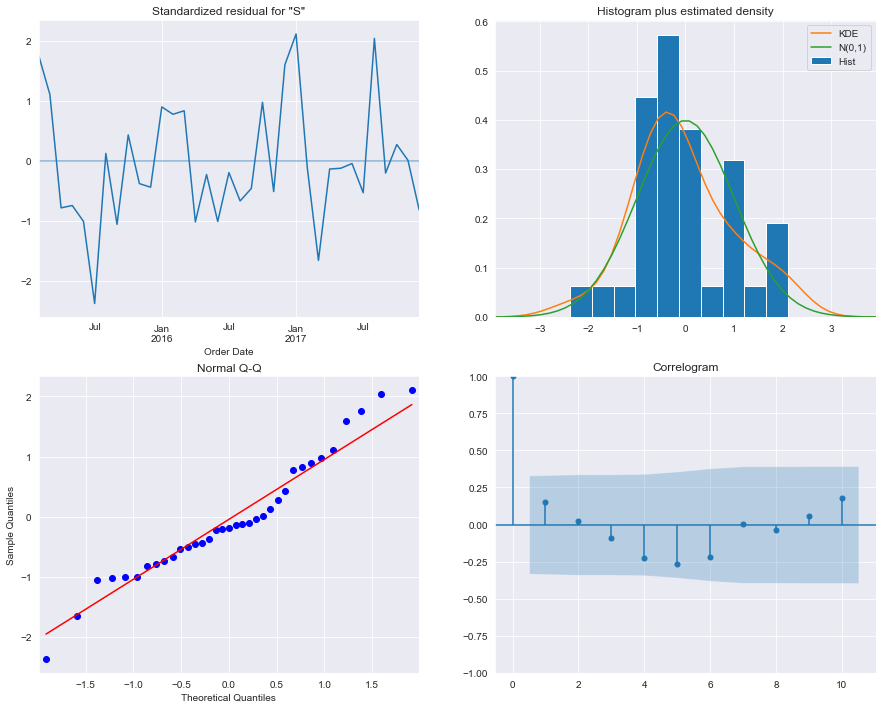

In [68]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Here residuals are near normally distributed from top right and botton left plots and the correlation plot shows uncorrelated.

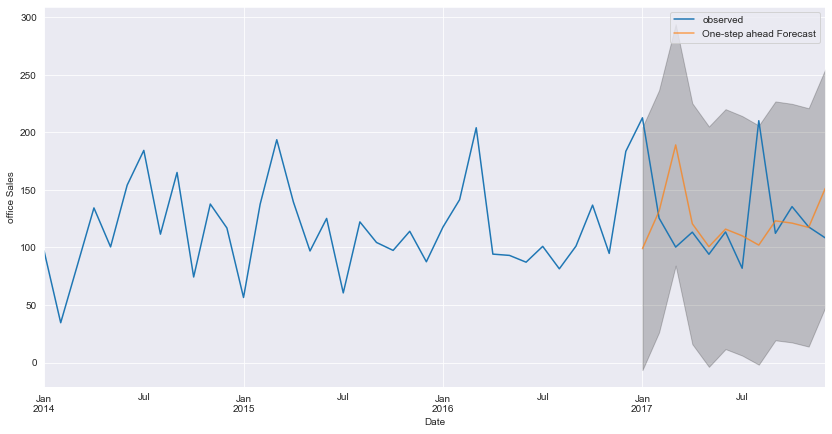

In [69]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y_office['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('office Sales')
plt.legend()

plt.show()


In [70]:
y_forecasted = pred.predicted_mean
y_truth = y_office['2017-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 2969.8
The Root Mean Squared Error of our forecasts is 54.5


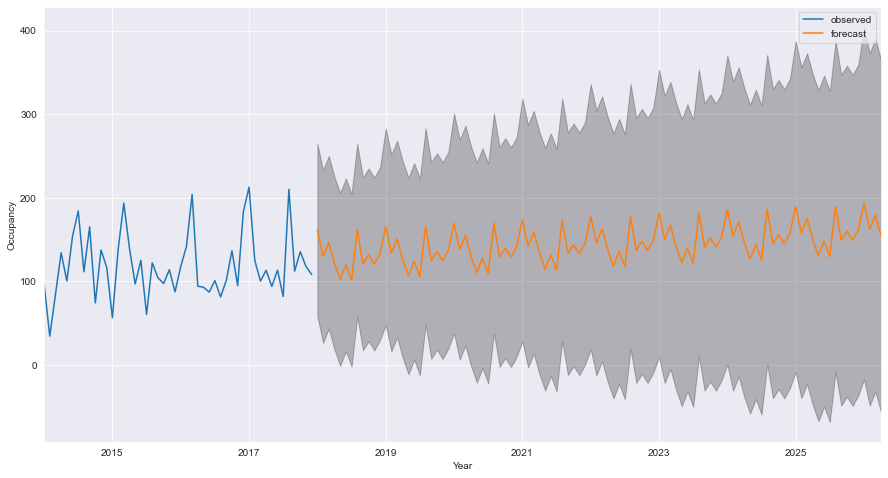

In [71]:
# Get forecast 100 steps ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = y_office.plot(label='observed', figsize=(15, 8))

pred_uc.predicted_mean.plot(ax=ax, label='forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Year')
ax.set_ylabel('Occupancy')

plt.legend()
plt.show()

## Technology

In [73]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_technology,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:721.5688506163442
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1487.6419240338735
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:506.0787430128274
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:322.98754525549793
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:514.1576203103061
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1493.5436371349388
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:337.72306528701387
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:324.3265655019672
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:683.3203705205927
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2654.197749724426
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:494.63999626653646
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:305.7104828501362
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:514.2823881454683
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2674.9444607170085
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:336.08723533603455
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:306.6135534234986
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:668.3045721205369
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1540.7215342379855
AR

ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:294.1604201223416 have lower AIC value.

In [110]:
model = sm.tsa.statespace.SARIMAX(y_technology,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                #enforce_stationarity=False,
                                enforce_invertibility=False)

results = model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1921      0.252     -0.763      0.446      -0.685       0.301
ma.L1         -1.0000   2308.723     -0.000      1.000   -4526.013    4524.013
ar.S.L12      -0.1574      0.258     -0.611      0.541      -0.663       0.348
ma.S.L12      -1.0000   2308.803     -0.000      1.000   -4526.171    4524.171
sigma2      1.511e+05      0.016   9.73e+06      0.000    1.51e+05    1.51e+05


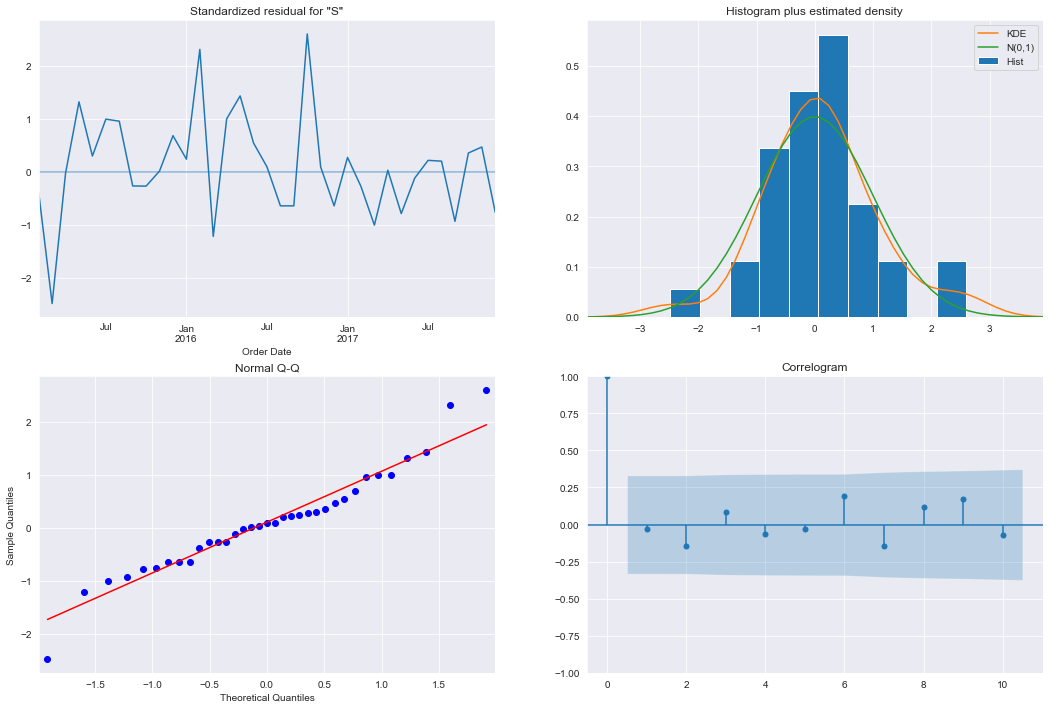

In [75]:
results.plot_diagnostics(figsize=(18, 12))
plt.show()

Top right plot shows a normally distributed curve with zero mean and correlation graph shows uncorrelation.

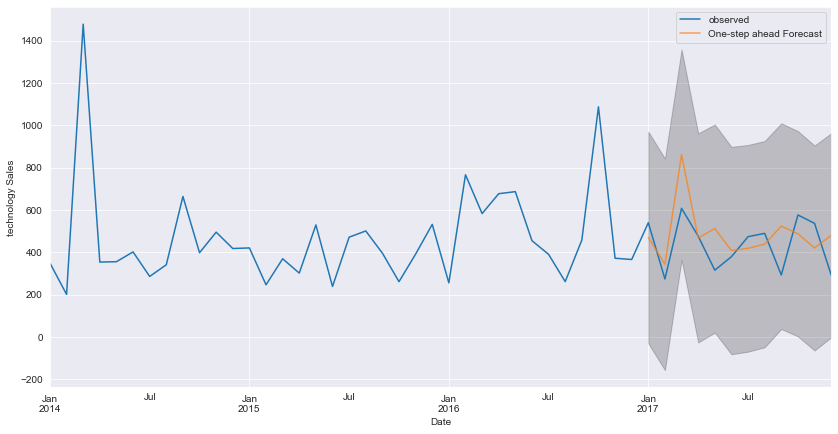

In [76]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y_technology['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('technology Sales')
plt.legend()

plt.show()


In [77]:
y_forecasted = pred.predicted_mean
y_truth = y_technology['2017-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 19069.96
The Root Mean Squared Error of our forecasts is 138.09


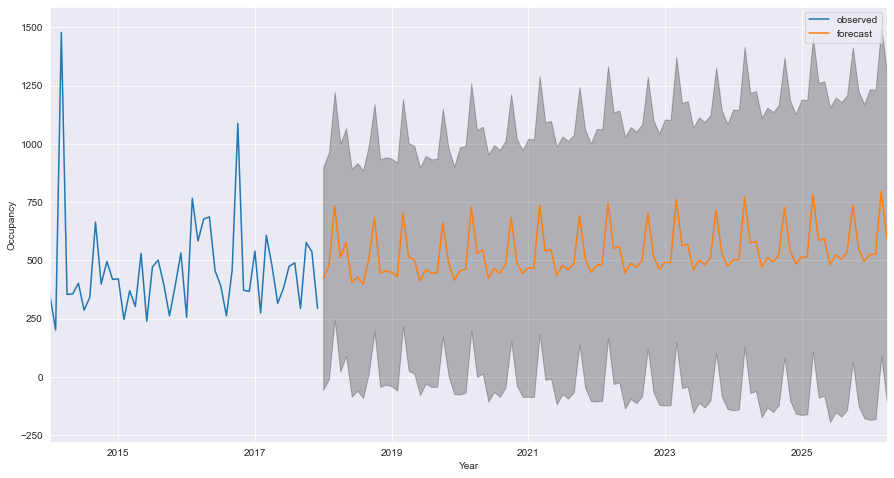

In [78]:
# Get forecast 100 steps ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = y_technology.plot(label='observed', figsize=(15, 8))

pred_uc.predicted_mean.plot(ax=ax, label='forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Year')
ax.set_ylabel('Occupancy')

plt.legend()
plt.show()

Increasing trend is observed from forecast for the sales of Technology products.

### Comparing categories

In [79]:
furniture_data.shape, office_supplies_data.shape, technology_data.shape

((2121, 1), (6026, 1), (1847, 1))

In [80]:
#furniture_data.drop(col, axis=1, inplace=True)
#office_supplies_data.drop(col, axis=1, inplace=True)
#technology_data(col, axis=1, inplace=True)

In [81]:
furniture_data = furniture_data.sort_values('Order Date')
office_supplies_data = office_supplies_data.sort_values('Order Date')
technology_data = technology_data.sort_values('Order Date')

furniture_data = furniture_data.groupby('Order Date')['Sales'].sum().reset_index()
office_supplies_data= office_supplies_data.groupby('Order Date')['Sales'].sum().reset_index()
technology_data = technology_data.groupby('Order Date')['Sales'].sum().reset_index()

furniture_data = furniture_data.set_index('Order Date')
office_supplies_data = office_supplies_data.set_index('Order Date')
technology_data = technology_data.set_index('Order Date')

y_furniture = furniture_data['Sales'].resample('MS').mean()
y_office = office_supplies_data['Sales'].resample('MS').mean()
y_technology = technology_data['Sales'].resample('MS').mean()

In [82]:
furniture = pd.DataFrame({'Order Date': y_furniture.index , 'Sales':y_furniture.values})
furniture.head()

,Order Date,Sales
0,2014-01-01,480.194231
1,2014-02-01,367.931600
2,2014-03-01,857.291529
3,2014-04-01,567.488357
4,2014-05-01,432.049188


In [83]:
office = pd.DataFrame({'Order Date': y_office.index , 'Sales':y_office.values})
office.head()

,Order Date,Sales
0,2014-01-01,285.357647
1,2014-02-01,63.042588
2,2014-03-01,391.176318
3,2014-04-01,464.794750
4,2014-05-01,324.346545


In [84]:
technology = pd.DataFrame({'Order Date': y_technology.index , 'Sales':y_technology.values})
technology.head()

,Order Date,Sales
0,2014-01-01,449.041429
1,2014-02-01,229.787143
2,2014-03-01,2031.948375
3,2014-04-01,613.028933
4,2014-05-01,564.698588


In [85]:
store = pd.merge(furniture,office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales', 'Sales_z': 'technology_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


In [86]:
store_office_furniture_technology = technology.merge(store, how='inner', on='Order Date')
store_office_furniture_technology.rename(columns={'Sales': 'technology_sales', 'Sales_x':'furniture_sales','Sales_y':'office_sales'},inplace=True)
store_office_furniture_technology

,Order Date,technology_sales,furniture_sales,office_sales
0,2014-01-01,449.041429,480.194231,285.357647
1,2014-02-01,229.787143,367.931600,63.042588
2,2014-03-01,2031.948375,857.291529,391.176318
3,2014-04-01,613.028933,567.488357,464.794750
4,2014-05-01,564.698588,432.049188,324.346545
5,2014-06-01,766.905909,695.059242,588.774409
6,2014-07-01,533.608933,601.169500,756.060400
7,2014-08-01,708.435385,457.521656,541.879143
8,2014-09-01,2035.838133,992.353367,1015.677704
9,2014-10-01,596.900900,769.015437,267.078815


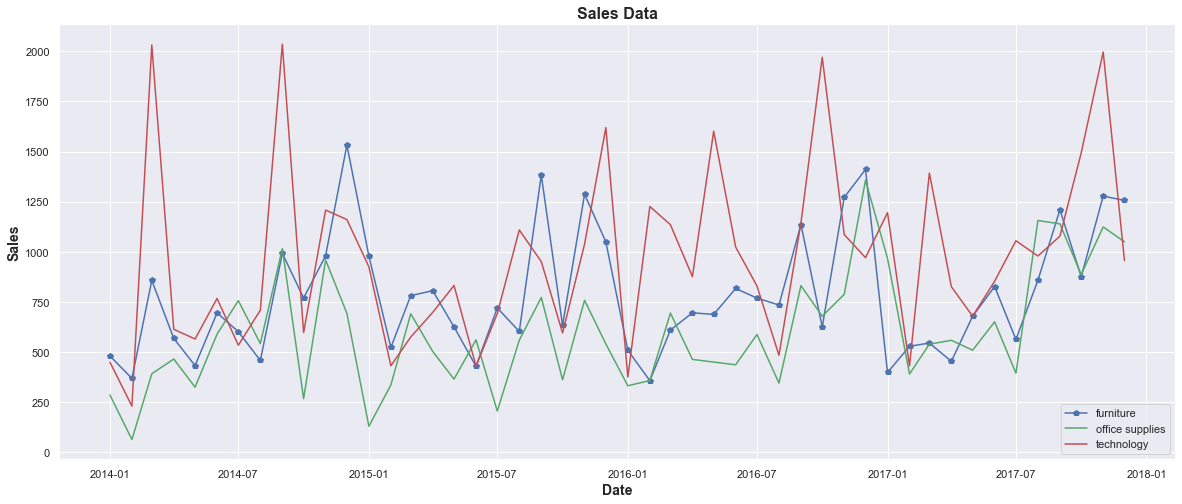

In [92]:
sns.set(font_scale=1)
plt.figure(figsize=(20,8))
plt.plot(store_office_furniture_technology['Order Date'],store_office_furniture_technology['furniture_sales'],'p-',label='furniture')
plt.plot(store_office_furniture_technology['Order Date'],store_office_furniture_technology['office_sales'],'g-',label='office supplies')
plt.plot(store_office_furniture_technology['Order Date'],store_office_furniture_technology['technology_sales'],'r-', label='technology')
plt.xlabel('Date',fontsize=14,fontweight='bold')
plt.ylabel('Sales', fontsize = 14,fontweight='bold')
plt.title('Sales Data', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

#### Findings:
- from above plot, it is clear that technology items are most selling item compare to other categories and sales of office supplies is least.
        
- sales of technology items is more than 2000 in the year 2014 but after that sales is declining in 2015.
    
- Sales of furniture items shows a maximum at the end of year 2014 and a similiar rise occurs in second half of 2015 and 2016.
        
- office supplies has maximum sales at the end of 2016.

In [89]:
#sns.set(font_scale=1)
#sns.relplot(data=store_office_furniture_technology, kind='line',height=10, aspect=1).set(title='Sales Data');
#plt.xlabel('Date')
#plt.ylabel('Sales')
#plt.show()

### comparing sales of different categories

### a) Furniture vs office items

In [93]:
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


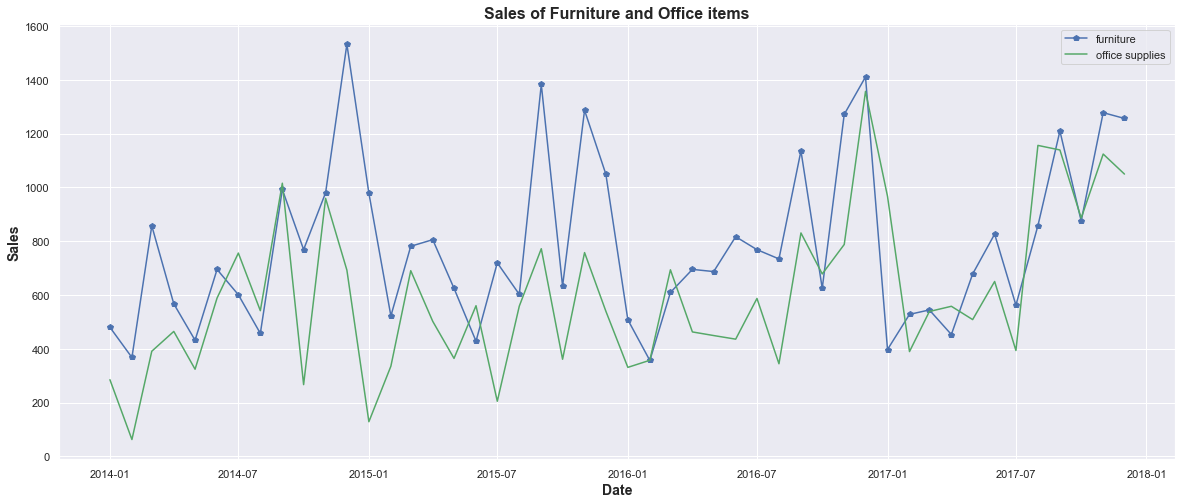

In [101]:
plt.figure(figsize=(20,8))

plt.plot(store['Order Date'],store['furniture_sales'],'p-',label='furniture')
plt.plot(store['Order Date'],store['office_sales'],'g-',label='office supplies')

plt.xlabel('Date',fontsize=14,fontweight='bold')
plt.ylabel('Sales', fontsize = 14,fontweight='bold')
plt.title('Sales of Furniture and Office items', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

### b) Furniture vs Technology items sales

In [95]:
store_furniture_technology = pd.merge(furniture,technology, how='inner', on='Order Date')
store_furniture_technology.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'technology_sales'}, inplace=True)
store_furniture_technology.head()

,Order Date,furniture_sales,technology_sales
0,2014-01-01,480.194231,449.041429
1,2014-02-01,367.931600,229.787143
2,2014-03-01,857.291529,2031.948375
3,2014-04-01,567.488357,613.028933
4,2014-05-01,432.049188,564.698588


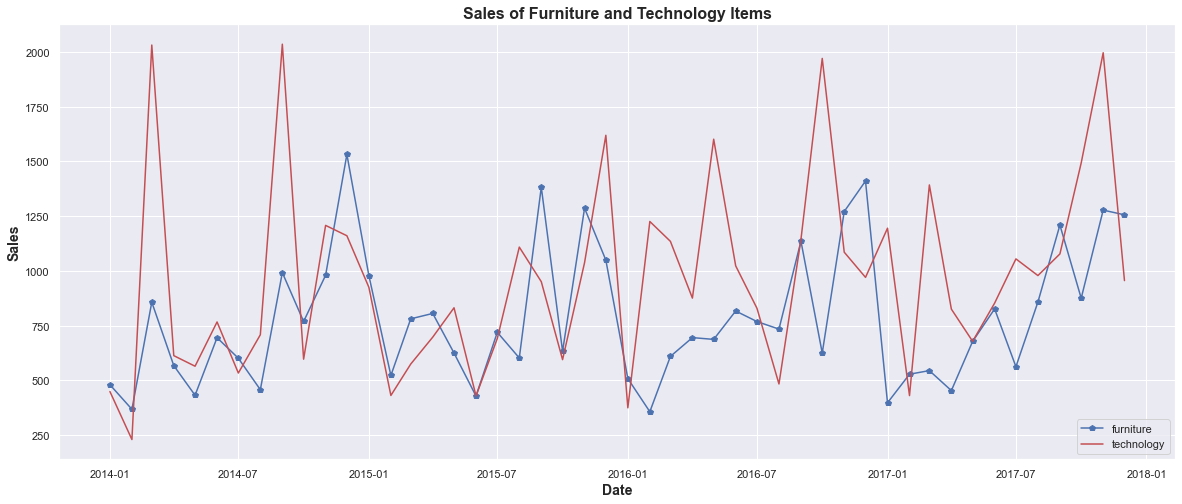

In [100]:
plt.figure(figsize=(20,8))
plt.plot(store_furniture_technology ['Order Date'],store_furniture_technology ['furniture_sales'],'p-',label='furniture')
plt.plot(store_furniture_technology ['Order Date'],store_furniture_technology ['technology_sales'],'r-', label='technology')
plt.xlabel('Date',fontsize=14,fontweight='bold')
plt.ylabel('Sales', fontsize = 14,fontweight='bold')
plt.title('Sales of Furniture and Technology Items', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

### c) office items vs technology sales

In [97]:
store_office_technology = pd.merge(office,technology, how='inner', on='Order Date')
store_office_technology.rename(columns={'Sales_x': 'office_sales', 'Sales_y': 'technology_sales'}, inplace=True)
store_office_technology.head()

,Order Date,office_sales,technology_sales
0,2014-01-01,285.357647,449.041429
1,2014-02-01,63.042588,229.787143
2,2014-03-01,391.176318,2031.948375
3,2014-04-01,464.794750,613.028933
4,2014-05-01,324.346545,564.698588


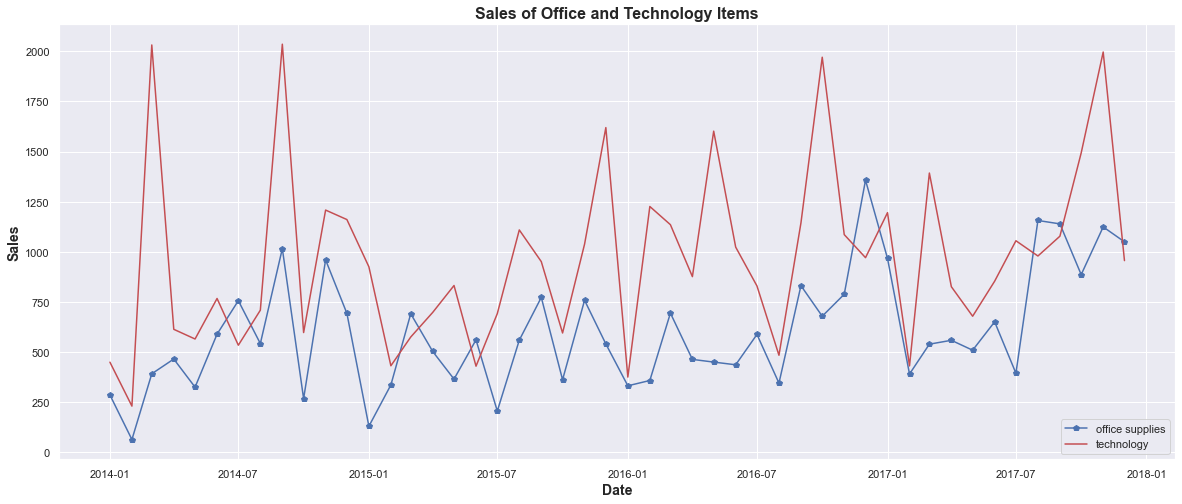

In [99]:
plt.figure(figsize=(20,8))
plt.plot(store_office_technology ['Order Date'],store_office_technology ['office_sales'],'p-',label='office supplies')
plt.plot(store_office_technology ['Order Date'],store_office_technology ['technology_sales'],'r-', label='technology')
plt.xlabel('Date',fontsize=14,fontweight='bold')
plt.ylabel('Sales', fontsize = 14,fontweight='bold')
plt.title('Sales of Office and Technology Items', fontsize=16, fontweight='bold')
plt.legend()
plt.show()